In [4]:
!pip install xbatcher

# Dask start

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36519")

# Import

In [2]:
import sys
sys.path.insert(1, '..')

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import gcm_filters
from dask import compute
import xgcm
import xesmf as xe
import os
from intake import open_catalog
import xbatcher

In [4]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
#%matplotlib widget
%matplotlib inline

# Load data

## eNATL60 grid

In [64]:
# #wget https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/eNATL60/eNATL60-I/mesh_mask_eNATL60.nc
# full_grid_HR = xr.open_dataset('/tmp/mesh_mask_eNATL60.nc', chunks='auto')

# full_grid_HR_2D = full_grid_HR.isel(t=0, z=22, drop=True)[['tmask', 'umask', 'vmask', 'fmask', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'nav_lon', 'nav_lat']]

# full_grid_HR_2D.to_netcdf("full_grid_HR_2D.nc")

# del full_grid_HR

In [65]:
full_grid_HR_2D = xr.open_dataset('full_grid_HR_2D.nc')

In [66]:
print(full_grid_HR_2D.nbytes / 1e9, "GiB")

3.002461016 GiB


## Temp and salinity data

In [67]:
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1164/eNATL60_wtides_1d_tsw60m.zarr"
input_ds = xr.open_dataset(store, engine='zarr', chunks={}).drop(['deptht', 'depthw', 'vovecrtz']).load()

In [68]:
input_ds

<xarray.Dataset>
Dimensions:       (y: 4729, x: 8354, time_counter: 2)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T12:00:00 2009-07-0...
Dimensions without coordinates: y, x
Data variables:
    nav_lat       (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    nav_lon       (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vosaline      (time_counter, y, x) float32 nan nan nan nan ... nan nan nan
    votemper      (time_counter, y, x) float32 nan nan nan nan ... nan nan nan
Attributes:
    CASE:                       N/A
    CONFIG:                     N/A
    NCO:                        netCDF Operators version 4.7.4-alpha04 (http:...
    history:                    Mon Sep 12 15:13:15 2022: ncap2 -O -s depthw=...
    history_of_appended_files:  Mon Sep 12 15:13:15 2022: Appended file /mnt/...
    nco_openmp_thread_number:   1
    output_frequency:           N/A
    pangeo-forge:inputs_hash:   de15ba5766c51a35969aafe033ddef0f91f3e9cd1ce51...
    pangeo-forge:recipe_hash:   ed684405d9c12c0c5685966beea54310056d73a31df66...
    pangeo-forge:version:       0.9.1
    start_date:                 -1

In [70]:
print(input_ds.nbytes / 1e9, "GiB")

1.264194128 GiB


# Grid metrics

In [71]:
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v'], # Y distances
    ('X', 'Y',): ['area'] # Areas 
}

Create and arrange the coordinates to make data suitable for xgcm and xESMF regridding :

In [80]:
ds_HR = xr.Dataset({},
               coords={"x_c": np.arange(len(input_ds['x'])),\
                       "y_c": np.arange(len(input_ds['y'])) ,\
                       "t" : input_ds['time_counter'].values})

In [81]:
ds_HR.coords['e1t'] = xr.DataArray(full_grid_HR_2D['e1t'].values, dims=['y_c', 'x_c'])
ds_HR.coords['e2t'] = xr.DataArray(full_grid_HR_2D['e2t'].values, dims=['y_c', 'x_c'])
ds_HR.coords['tmask'] = xr.DataArray(full_grid_HR_2D['tmask'].values, dims=['y_c', 'x_c'])

In [82]:
ds_HR.coords['lat'] = xr.DataArray(full_grid_HR_2D['nav_lat'].values, dims=['y_c', 'x_c'])
ds_HR.coords['lon'] = xr.DataArray(full_grid_HR_2D['nav_lon'].values, dims=['y_c', 'x_c'])

In [83]:
ds_HR['votemper'] = input_ds['votemper'].\
reindex(y = ds_HR.y_c.values, x = ds_HR.x_c.values, method='bfill').\
rename(y='y_c', x='x_c', time_counter='t')

ds_HR['vosaline'] = input_ds['vosaline']\
.reindex(y = ds_HR.y_c.values, x = ds_HR.x_c.values, method='bfill').\
rename(y='y_c', x='x_c', time_counter='t')

CPU times: user 4.4 s, sys: 786 ms, total: 5.19 s
Wall time: 5.18 s


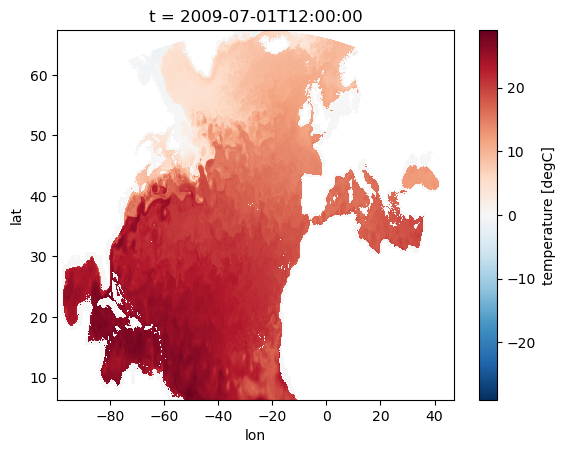

In [99]:
%%time
ds_HR.isel(t=0).votemper.plot(x='lon',y='lat')

# Computation of variables before coarsening

In [100]:
g = 9.80665 
rho_0 = 1023.6

In [101]:
def vars_before_coars(input_ds, grid) :
    ds = input_ds
    
    # Compute density
    ds['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, ds.vosaline, ds.votemper, dask='parallelized')
    
    # Squares for computing the subgrid variance
    ds['sigma0_true_sqr'] = ds['sigma0_true']**2
    ds['votemper_sqr'] = ds['votemper']**2
    ds['vosaline_sqr'] = ds['vosaline']**2
    return ds

# Splitting dataset

In [104]:
x_batch_size = int(len(input_ds.x)/4)
print(x_batch_size)
y_batch_size = int(len(input_ds.y)/4)
print(y_batch_size)

2088
1182


In [120]:
%%time
bgen = xbatcher.BatchGenerator(ds = ds_HR, 
                               input_dims={'x_c' : x_batch_size, 'y_c' : y_batch_size},
                               batch_dims={} )

CPU times: user 304 µs, sys: 0 ns, total: 304 µs
Wall time: 309 µs


In [121]:
len(bgen)

16

In [126]:
list_of_batches = [xr.Dataset() for i in range(len(bgen))]

In [128]:
for i, batch in enumerate(bgen):
    list_of_batches[i] = batch.dropna('x_c', how='all', thresh=None, subset=['votemper']).dropna('y_c', how='all', thresh=None, subset=['votemper'])

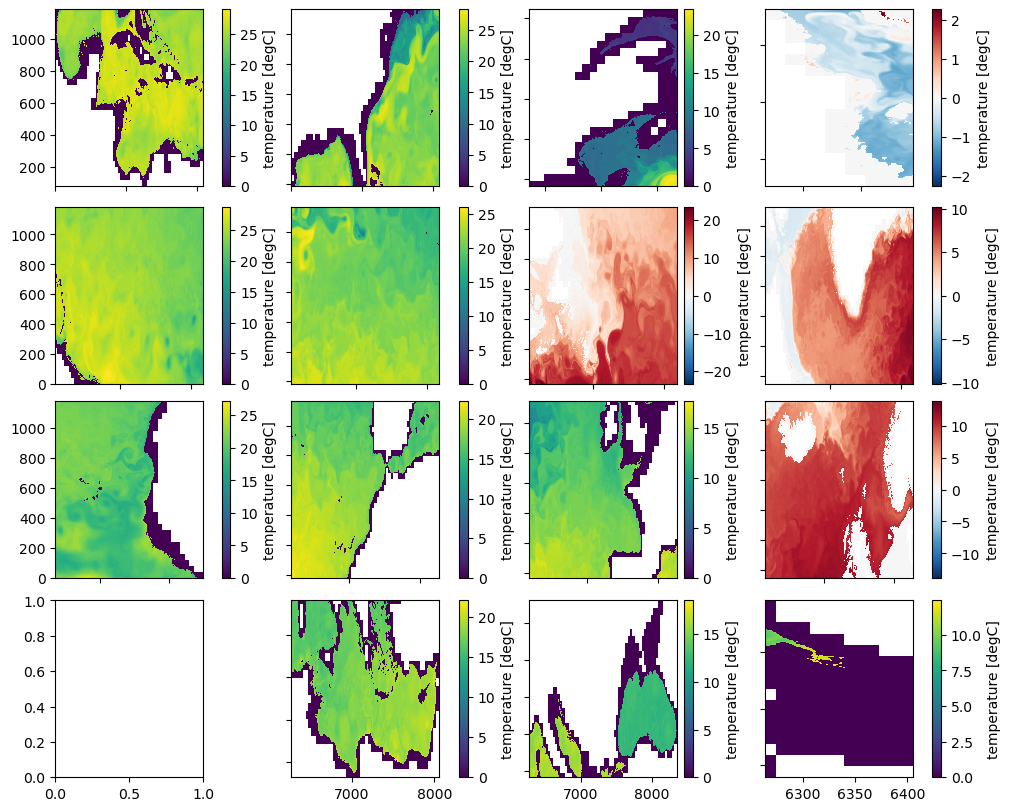

CPU times: user 16.7 s, sys: 1.14 s, total: 17.9 s
Wall time: 17.8 s


In [132]:
%%time
fig, axs = plt.subplots(4, 4, constrained_layout=True, figsize=(10,8))
for i, batch in enumerate(list_of_batches):
    if (len(batch.x_c) > 0) & (len(batch.y_c) > 0) :
        batch.isel(t=0)['votemper'].plot(ax=axs.flat[i])
    axs.flat[i].set(title='', xlabel='', ylabel='')
    axs.flat[i].label_outer()
plt.show()

# Prepare data for coarsening

In [26]:
ds_HR.coords['area'] = ds_HR['e1t']*ds_HR['e2t']

In [124]:
ds_HR = vars_before_coars(ds_HR, HR_grid)
ds_HR = ds_HR.drop_vars(['e1t', 'e2t'], errors='ignore').\
rename({'x_c' : 'x', 'y_c' : 'y', 'tmask' : 'mask'})

In [27]:
# Preparation of corner coordinates for the regridder
ds_HR = xgcm.autogenerate.generate_grid_ds(ds_HR, axes_dims_dict={'X' : 'x_c', 'Y' : 'y_c'}, \
                                            axes_coords_dict={'X' : 'lon', 'Y' : 'lat'}, position=('center', 'outer'))
ds_HR = ds_HR.rename({'x_c_outer': 'x_b','y_c_outer': 'y_b'})

In [28]:
HR_grid= xgcm.Grid(ds_HR, metrics=metrics, periodic=False, \
                     coords={'X' : {'center' : 'x_c', 'right' : 'x_r', 'outer' : 'x_b'}, \
                            'Y' : {'center' : 'y_c', 'right' : 'y_r', 'outer' : 'y_b'}})

In [29]:
ds_HR.coords['lon_b'] = HR_grid.interp(da=ds_HR['lon_outer'].load(), axis='Y', to='outer',boundary='extend')
ds_HR.coords['lat_b'] = HR_grid.interp(da=ds_HR['lat_outer'].load(), axis='X', to='outer',boundary='extend')

In [30]:
ds_HR = ds_HR.chunk(chunk_dict | {'x_b' : -1, 'y_b' : -1})

In [31]:
ds_HR = ds_HR.load()

In [32]:
ds_HR

<xarray.Dataset>
Dimensions:    (x_c: 8354, y_c: 4729, x_r: 8354, y_r: 4729, t: 2, x_b: 8355,
                y_b: 4730)
Coordinates: (12/26)
  * x_c        (x_c) int64 0 1 2 3 4 5 6 ... 8347 8348 8349 8350 8351 8352 8353
  * y_c        (y_c) int64 0 1 2 3 4 5 6 ... 4722 4723 4724 4725 4726 4727 4728
  * x_r        (x_r) float64 0.5 1.5 2.5 3.5 ... 8.352e+03 8.352e+03 8.354e+03
  * y_r        (y_r) float64 0.5 1.5 2.5 3.5 ... 4.726e+03 4.728e+03 4.728e+03
  * t          (t) datetime64[ns] 2009-07-01T12:00:00 2009-07-02T12:00:00
    e1t        (y_c, x_c) float64 1.842e+03 1.842e+03 ... 1.006e+03 1.006e+03
    ...         ...
  * x_b        (x_b) float64 -0.5 0.5 1.5 2.5 ... 8.352e+03 8.352e+03 8.354e+03
  * y_b        (y_b) float64 -0.5 0.5 1.5 2.5 ... 4.726e+03 4.728e+03 4.728e+03
    lon_outer  (y_c, x_b) float32 -97.89 -97.88 -97.86 ... 47.11 47.12 47.14
    lat_outer  (y_b, x_c) float32 6.329 6.329 6.329 6.329 ... 54.43 54.42 54.42
    lon_b      (y_b, x_b) float32 -97.89 -97.88 -97.86 ... 47.11 47.12 47.14
    lat_b      (y_b, x_b) float32 6.329 6.329 6.329 6.329 ... 54.43 54.42 54.42
Data variables:
    votemper   (t, y_c, x_c) float32 nan nan nan nan nan ... nan nan nan nan nan
    vosaline   (t, y_c, x_c) float32 nan nan nan nan nan ... nan nan nan nan nan

In [33]:
print(ds_HR.nbytes / 1e9, "GiB")

4.583174684 GiB


# Computation of variablles after coarsening

In [36]:
def vars_after_coars(input_ds, grid) :
    ds = input_ds
    ds['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, ds.vosaline, ds.votemper, dask='parallelized')
    
    # density error
    ds['sigma0_delta'] = ds['sigma0_true'] - ds['sigma0_model']  
    
    # subgrid variance
    for var in ['votemper', 'vosaline'] :
        ds[var+'_var'] = ds[var+'_sqr'] - ds[var]**2
    
    # second derivatives of EOS
    temp_pressure = xr.zeros_like(ds.sosstsst)
    temp_array = xr.apply_ufunc(gsw.rho_second_derivatives, ds.vosaline, ds.votemper, temp_pressure, \
                            input_core_dims = [('t', 'y_c', 'x_c') for i in range(3)],\
                           output_core_dims = [('t', 'y_c', 'x_c') for i in range(5)],\
                           dask='parallelized', dask_gufunc_kwargs=dict({'allow_rechunk' : True})) 
    ds['rho_sa_sa'] = xr.DataArray(temp_array[0], dims=['t', 'y_c', 'x_c'])
    ds['rho_sa_ct'] = xr.DataArray(temp_array[1], dims=['t', 'y_c', 'x_c'])
    ds['rho_ct_ct'] = xr.DataArray(temp_array[2], dims=['t', 'y_c', 'x_c'])
    ds['rho_sa_p'] = xr.DataArray(temp_array[3], dims=['t', 'y_c', 'x_c'])
    ds['rho_ct_p'] = xr.DataArray(temp_array[4], dims=['t', 'y_c', 'x_c'])
    del temp_array, temp_pressure
    
    # horizontal derivatives
    for variable in ['votemper', 'vosaline', 'sigma0_model', 'sigma0_delta', 'votemper_var', 'vosaline_var'] :
        for axis in ['X', 'Y'] :
            ds['diff_'+axis+'_'+variable] = grid.diff(ds[variable], axis=axis, boundary='extend')
        ds['diff_'+variable+'_sqr'] = grid.interp(ds['diff_X_'+variable]**2, 'X') + \
                                   grid.interp(ds['diff_Y_'+variable]**2, 'Y')    
        
    # predictors 
    ds['predictor_T'] = 0.5*ds['rho_ct_ct']*ds['diff_votemper_sqr']
    ds['predictor_S'] = 0.5*ds['rho_sa_sa']*ds['diff_vosaline_sqr']
    ds['predictor_TS'] = 0.5*ds['rho_sa_ct']*np.sqrt(ds['diff_vosaline_sqr']*ds['diff_votemper_sqr'])
    
    return ds

# Coasening

In [37]:
global_grid_LR = xr.open_dataset('../global_eORCA025_mesh.nc', chunks=None)
global_grid_LR.coords['area'] = global_grid_LR['e1t']*global_grid_LR['e2t']

In [38]:
global_grid_LR

<xarray.Dataset>
Dimensions:  (y: 1205, y_r: 1205, x: 1440, x_r: 1440, x_b: 1441, y_b: 1206)
Coordinates: (12/29)
  * y        (y) int64 1 2 3 4 5 6 7 8 ... 1199 1200 1201 1202 1203 1204 1205
  * y_r      (y_r) float64 1.5 2.5 3.5 4.5 ... 1.204e+03 1.204e+03 1.206e+03
  * x        (x) int64 1 2 3 4 5 6 7 8 ... 1434 1435 1436 1437 1438 1439 1440
  * x_r      (x_r) float64 1.5 2.5 3.5 4.5 ... 1.438e+03 1.44e+03 1.44e+03
    lat      (y, x) float64 -84.17 -84.17 -84.17 -84.17 ... 50.07 50.02 50.0
    llat_cr  (y, x_r) float64 ...
    ...       ...
    fmask    (y_r, x_r) int8 ...
  * x_b      (x_b) float64 0.5 1.5 2.5 3.5 ... 1.438e+03 1.44e+03 1.44e+03
  * y_b      (y_b) float64 0.5 1.5 2.5 3.5 ... 1.204e+03 1.204e+03 1.206e+03
    lon_b    (y_b, x_b) float64 ...
    lat_b    (y_b, x_b) float64 ...
    area     (y, x) float64 1.0 1.0 1.0 1.0 ... 3.958e+06 6.027e+06 6.569e+03
Data variables:
    *empty*

In [39]:
SCRATCH_BUCKET = os.environ['SCRATCH_BUCKET'] 

In [44]:
%%time
# to take a part of the LR global grid corresponding to the data cut
selection = global_grid_LR.lon.where((global_grid_LR.lon>=ds_HR.lon.min().values) & (global_grid_LR.lon<=ds_HR.lon.max().values) &\
                              (global_grid_LR.lat>=ds_HR.lat.min().values) & (global_grid_LR.lat<=ds_HR.lat.max().values), drop=True)
selected_x = list(selection.x.values)
selected_y = list(selection.y.values)
sel_grid_LR = global_grid_LR.isel(x=selected_x[0:-1], x_b=selected_x, y=selected_y[0:-1], y_b=selected_y, x_r=selected_x[0:-1], y_r=selected_y[0:-1])

CPU times: user 676 ms, sys: 210 ms, total: 887 ms
Wall time: 3.24 s


In [45]:
# reinit x and y arrays
sel_grid_LR.coords['x'] = np.arange(1,len(selected_x)); sel_grid_LR.coords['y'] = np.arange(1,len(selected_y))
sel_grid_LR.coords['x_b'] = np.arange(1,len(selected_x)+1)-0.5; sel_grid_LR.coords['y_b'] = np.arange(1,len(selected_y)+1)-0.5
sel_grid_LR.coords['x_r'] = np.arange(1,len(selected_x))+0.5; sel_grid_LR.coords['y_r'] = np.arange(1,len(selected_y))+0.5

In [ ]:
%%time
# create regridder, i.e. compute weights
# TODO : save weights and reuse them (can accelerate pre-treatment)
regridder = xe.Regridder(ds_HR, sel_grid_LR, method="conservative_normed")

In [ ]:
%%time
# perform coarsening
ds_LR = regridder(ds)
ds_LR = ds_LR.drop_dims(['x_b', 'y_b'])
ds_LR = xr.merge([sel_grid_LR.drop_dims(['x_b', 'y_b']), ds_LR], compat='override')
ds_LR = (ds_LR.rename({'x': 'x_c', 'y' : 'y_c'}))

In [ ]:
#create grid for xgcm
metrics_LR = {
    ('X',): ['e1t', 'e1u', 'e1v'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v'], # Y distances
    ('X', 'Y',): ['area'] }

In [ ]:
LR_grid = xgcm.Grid(data_entity['LR'], metrics=metrics_LR, periodic=False, \
                    coords={'X' : {'center' : 'x_c', 'right' : 'x_r'}, \
                            'Y' : {'center' : 'y_c', 'right' : 'y_r'}})

In [ ]:
# Calculate LR variables
ds_LR = vars_after_coars(ds_LR, LR_grid)

In [ ]:
# write on disk
#new_LR.to_netcdf("/tmp/dataLR"+str(i)+".nc")
new_LR.to_zarr(store=f'{SCRATCH_BUCKET}/coarsened_full_eNATL60.zarr', mode='w')  # write data

In [ ]:
print(ds_LR.nbytes / 1e6, "MiB")

In [ ]:
%%time
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3.5), constrained_layout=True)
ds.votemper.isel(t=0).plot(ax=ax[0], x='lon', y='lat')
ds_LR.votemper.isel(t=0).plot(ax=ax[1], x='lon', y='lat')
ax[0].set(title='eNATL60')
ax[1].set(title='Coarsened to 1/4 deg')

In [ ]:
global_grid_LR['mask'].where((global_grid_LR.lon<8) & (global_grid_LR.lon>-2) & \
                             (global_grid_LR.lat>35) & (global_grid_LR.lat<44), drop=True).mask.plot()